In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import librosa
import os
import random
import seaborn as sns
import pandas as pd
import pickle
import math
import torchaudio

from torchaudio.transforms import TimeMasking, FrequencyMasking
from torchvision.ops import SqueezeExcitation
from torchinfo import summary
from torchsummary import summary
from torchvision.ops import SqueezeExcitation
from tqdm import tqdm
from torchvision import datasets, transforms
from collections import defaultdict
from torchvision.transforms import Compose, ToTensor
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from scipy.io import wavfile
from functools import reduce
from sklearn import metrics 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

pd.set_option('future.no_silent_downcasting', True)

c:\Users\user\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Loading data

In [2]:
keys_s = '0123456789abcdefghijklmnopqrstuvwxyz'
labels = list(keys_s)
keys = [k + '.wav' for k in labels]
data_dict = {'Key':[], 'File':[]}

In [3]:
def isolator(signal, sample_rate, size, scan, before, after, threshold, show=False):
    strokes = []
    # -- signal'
    if show:
        plt.figure(figsize=(7, 2))
        librosa.display.waveshow(signal, sr=sample_rate)
    fft = librosa.stft(signal, n_fft=size, hop_length=scan)
    energy = np.abs(np.sum(fft, axis=0)).astype(float)
    # norm = np.linalg.norm(energy)
    # energy = energy/norm
    # -- energy'
    if show:
        plt.figure(figsize=(7, 2))
        librosa.display.waveshow(energy)
    threshed = energy > threshold
    # -- peaks'
    if show:
        plt.figure(figsize=(7, 2))
        librosa.display.waveshow(threshed.astype(float))
    peaks = np.where(threshed == True)[0]
    peak_count = len(peaks)
    prev_end = sample_rate*0.1*(-1)
    # '-- isolating keystrokes'
    for i in range(peak_count):
        this_peak = peaks[i]
        timestamp = (this_peak*scan) + size//2
        if timestamp > prev_end + (0.1*sample_rate):
            keystroke = signal[timestamp-before:timestamp+after]
            strokes.append(torch.tensor(keystroke)[None, :])
            if show:
                plt.figure(figsize=(7, 2))
                librosa.display.waveshow(keystroke, sr=sample_rate)
            prev_end = timestamp+after
    return strokes

def convert_to_df(AUDIO_FILE):
    for i, File in enumerate(keys):
        loc = AUDIO_FILE + File
        samples, sample_rate = librosa.load(loc, sr=None)
        #samples = samples[round(1*sample_rate):]
        strokes = []
        prom = 0.06
        step = 0.005
        while not len(strokes) == 25:
            strokes = isolator(samples[1*sample_rate:], sample_rate, 48, 24, 2400, 12000, prom, False)
            if len(strokes) < 25:
                prom -= step
            if len(strokes) > 25:
                prom += step
            if prom <= 0:
                print('-- not possible for: ',File)
                break
            step = step*0.99
        label = [labels[i]]*len(strokes)
        data_dict['Key'] += label
        data_dict['File'] += strokes

    df = pd.DataFrame(data_dict)
    mapper = {}
    counter = 0
    for l in df['Key']:
        if not l in mapper:
            mapper[l] = counter
            counter += 1
    df.replace({'Key': mapper}, inplace=True)
    return df, sample_rate 

In [4]:
data_frame, sr = convert_to_df("../../dataset/Zoom/")

print(data_frame.head())
print(data_frame.info())

  Key                                               File
0   0  [[tensor(-6.1035e-05), tensor(-6.1035e-05), te...
1   0  [[tensor(0.), tensor(-3.0518e-05), tensor(-3.0...
2   0  [[tensor(3.0518e-05), tensor(3.0518e-05), tens...
3   0  [[tensor(-0.0002), tensor(-0.0002), tensor(-0....
4   0  [[tensor(6.1035e-05), tensor(6.1035e-05), tens...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Key     900 non-null    object
 1   File    900 non-null    object
dtypes: object(2)
memory usage: 14.2+ KB
None


In [5]:
train_set, tmp_set = train_test_split(data_frame, test_size=0.3, stratify=data_frame['Key'])
val_set, test_set = train_test_split(tmp_set, test_size=0.33, stratify=tmp_set['Key'])

print("Sample rate:", sr)
print(len(train_set), len(val_set), len(test_set))

Sample rate: 32000
630 180 90


### Data augmentation setup

In [6]:
class MyDataset(Dataset):
    def __init__(self, file_name, transform = None, aug = None):
        df = file_name
        self.transform = transform
        self.aug = aug
        self.labels = df['Key']
        self.values = df['File']
        
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, index):
        label = self.labels.iloc[index]
        value = self.values.iloc[index]
        waveform = self.values.iloc[index]
        label = self.labels.iloc[index]
        if self.transform:
            waveform = waveform.numpy()
            waveform = waveform.flatten()
            waveform = self.transform(waveform)
        if self.aug:
            waveform = self.aug(waveform)
        return waveform, label

class ToMelSpectrogram:
    def __call__(self, samples):
#         samples = np.array(samples)
        spec = librosa.feature.melspectrogram(y = samples, sr = sr, n_mels=64, n_fft=2048, win_length=1024, hop_length=226)
        return librosa.power_to_db(spec)

class TimeShifting():
    def __call__(self, samples):
        samples = samples.numpy()
        samples = samples.flatten()
        
        shift = int(len(samples) * 0.4)
        random_shift =random.randint(0, shift)
        data_roll = np.roll(samples, random_shift)
        return data_roll
    
class SpecAugment():
    def __call__(self, samples):
        num_mask = 2
        freq_masking_max_percentage=0.10
        time_masking_max_percentage=0.10
        spec = samples.copy()
        mean_value = spec.mean()
        for i in range(num_mask):
            all_frames_num, all_freqs_num = spec.shape[1], spec.shape[1] 
            freq_percentage = random.uniform(0.0, freq_masking_max_percentage)

            num_freqs_to_mask = int(freq_percentage * all_freqs_num)
            f0 = np.random.uniform(low=0.0, high=all_freqs_num - num_freqs_to_mask)
            f0 = int(f0)
            spec[:, f0:f0 + num_freqs_to_mask] = mean_value

            time_percentage = random.uniform(0.0, time_masking_max_percentage)

            num_frames_to_mask = int(time_percentage * all_frames_num)
            t0 = np.random.uniform(low=0.0, high=all_frames_num - num_frames_to_mask)
            t0 = int(t0)
            spec[t0:t0 + num_frames_to_mask, :] = mean_value
        return spec

aug = Compose([
    TimeShifting(),
    ToMelSpectrogram(),
    SpecAugment(),
    ToTensor()
    ])

transform = Compose([
    ToMelSpectrogram(),
    ToTensor()])
        
train_set = MyDataset(train_set, aug = aug)
val_set = MyDataset(val_set, transform = transform)
test_set = MyDataset(test_set, transform = transform)

### Training set image (augmented vs non-augmented)

torch.Size([64, 64])


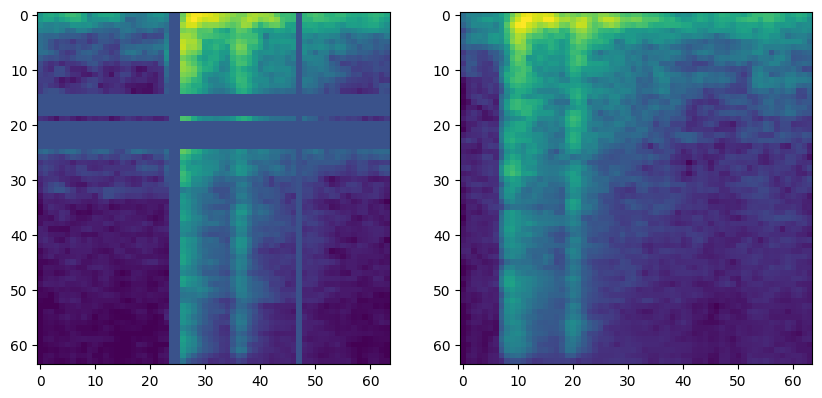

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(train_set[0][0][0], cmap='viridis')
ax2.imshow(val_set[0][0][0], cmap='viridis')
print(train_set[0][0][0].shape)
ax1.grid(False)
ax2.grid(False)
plt.show()

In [8]:
print("number of classes:", len(np.unique(data_frame['Key'])))

number of classes: 36


### CoAtNet (Model)

In [9]:
class Stem(nn.Sequential):
    def __init__(self, out_channels):
        super().__init__(
            nn.Conv2d(1, out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3)
        )

In [10]:
class MBConv(nn.Module):
    def __init__(self, in_channels, out_channels, expansion_factor=4):
        super().__init__()
        self.mb_conv = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, in_channels * expansion_factor, kernel_size=1),
            nn.BatchNorm2d(in_channels * expansion_factor),
            nn.GELU(),
            nn.Conv2d(in_channels * expansion_factor, in_channels * expansion_factor, kernel_size=3, padding=1, groups=in_channels * expansion_factor),
            nn.BatchNorm2d(in_channels * expansion_factor),
            nn.GELU(),
            SqueezeExcitation(in_channels * expansion_factor, in_channels, activation=nn.GELU),
            nn.Conv2d(in_channels * expansion_factor, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels)
        )
    
    def forward(self, x):
        return x + self.mb_conv(x)

In [11]:
class DownsamplingMBConv(MBConv):
    def __init__(self, in_channels, out_channels, expansion_factor=4):
        super().__init__(in_channels, out_channels, expansion_factor=4)
        self.mb_conv[1] = nn.Conv2d(in_channels, in_channels * expansion_factor, kernel_size=1, stride = 2)
        self.channel_projection = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    
    def forward(self, x):
        return self.channel_projection(self.pool(x)) + self.mb_conv(x)

In [12]:
class RelativeAttention2d(nn.Module):
    def __init__(self, in_channels, out_channels, image_size, heads=8, head_size=32):
        super().__init__()
        heads = out_channels // head_size
        self.heads = heads
        self.head_size = head_size
        self.image_size = image_size
        self.head_dim = heads * head_size
        self.attend = nn.Softmax(dim=-2) # Taken from My_CoAtNet
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        self.to_q = nn.Linear(in_channels, self.head_dim)
        self.to_k = nn.Linear(in_channels, self.head_dim)
        self.to_v = nn.Linear(in_channels, self.head_dim)
        self.to_output = nn.Sequential(
            nn.Linear(self.head_dim, out_channels),
            nn.Dropout(0.3)
        )
        self.normalization = nn.LayerNorm(in_channels)
        
        self.relative_bias = nn.Parameter(torch.randn(heads, (2 * image_size - 1) * (2 * image_size - 1)))
        self.register_buffer("relative_indices", self.get_indices(image_size, image_size)) # Taken from My_CoAtNet
        self.precomputed_relative_bias = None
    
    def norm(self, x):
        x = x.transpose(1, -1) # Taken from My_CoAtNet
        x = self.normalization(x)
        x = x.transpose(-1, 1) # Taken from My_CoAtNet
        return x
    
    def get_relative_biases(self):
        # Relative bias caching mentioned in CoAtNet: Marrying Convolution and Attention for All Data Sizes
        if not self.training:
            return self.precomputed_relative_bias
        # Taken from od My_CoAtNet
        indices = self.relative_indices.expand(self.heads, -1)
        rel_pos_enc = self.relative_bias.gather(-1, indices)
        rel_pos_enc = rel_pos_enc.unflatten(-1, (self.image_size * self.image_size, self.image_size * self.image_size))
        return rel_pos_enc
    
    def reshape_for_linear(self, x):
        b, _, _, _ = x.shape
        return x.reshape(b, self.image_size * self.image_size, self.in_channels)
    
    def attention_score(self, x):
        b, _, h, _ = x.shape
        q = self.to_q(self.reshape_for_linear(x)).view(b, self.heads, self.head_size, -1) # Taken from My_CoAtNet
        k = self.to_k(self.reshape_for_linear(x)).view(b, self.heads, self.head_size, -1) # Taken from My_CoAtNet
        dots = torch.matmul(k.transpose(-1, -2), q) / math.sqrt(self.head_dim)
        relative_biases_indexed = self.get_relative_biases()
        return self.attend(dots + relative_biases_indexed)
    
    def relative_attention(self, x):
        b, _, _, _ = x.shape
        v = self.to_v(self.reshape_for_linear(x)).view(b, self.heads, self.head_size, -1) # Taken from My_CoAtNet
        out = torch.matmul(v, self.attention_score(x)) # I figured this out after debugging (Still the same as My_CoAtNet)
        out = out.view(b, self.image_size, self.image_size, -1)
        return self.to_output(out).view(b, self.out_channels, self.image_size, self.image_size)
        
    def forward(self, x):
        return x + self.relative_attention(self.norm(x))
    
    def train(self, training):
        if not training:
            self.precomputed_relative_bias = self.get_relative_biases()
        super().train(training)
        
    # Taken from My_CoAtNet
    @staticmethod
    def get_indices(h, w):
        y = torch.arange(h, dtype=torch.long)
        x = torch.arange(w, dtype=torch.long)
        
        y1, x1, y2, x2 = torch.meshgrid(y, x, y, x)
        indices = (y1 - y2 + h - 1) * (2 * w - 1) + x1 - x2 + w - 1
        indices = indices.flatten()
        
        return indices
        

In [13]:
class DownsamplingRelativeAttention2d(RelativeAttention2d):
    def __init__(self, in_channels, out_channels, image_size, heads=8, head_size=32):
        super().__init__(in_channels, out_channels, image_size, heads=8, head_size=32)
        self.channel_projection = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.normalization = nn.LayerNorm(in_channels)


    def norm(self, x):
        x = x.transpose(1, -1) # Taken from My_CoAtNet
        x = self.normalization(x)
        x = x.transpose(-1, 1) # Taken from My_CoAtNet
        return x
        
    def forward(self, x):
        return self.channel_projection(self.pool(x)) + self.relative_attention(self.pool(self.norm(x)))

In [14]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, out_channels, expansion_factor=4):
        super().__init__()
        hidden_dim = out_channels * expansion_factor
        self.ffn = nn.Sequential(
            nn.Linear(out_channels, hidden_dim),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, out_channels),
            nn.Dropout(0.3)
        )
        self.normalization = nn.LayerNorm(out_channels)
        self.out_channels = out_channels

    
    def norm(self, x):
        x = x.transpose(1, -1) # Taken from My_CoAtNet
        x = self.normalization(x)
        x = x.transpose(-1, 1) # Taken from My_CoAtNet
        return x
    
    def forward(self, x):
        old_shape = x.shape
        batch_size = old_shape[0]
        return x + torch.reshape(self.ffn(torch.reshape(self.norm(x), (batch_size, -1, self.out_channels))), old_shape)
    

In [15]:
class DownsampleTransformerBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, image_size):
        attention = DownsamplingRelativeAttention2d(in_channels, out_channels, image_size)
        ffn = FeedForwardNetwork(out_channels)
        super().__init__(
            attention,
            ffn
        )

In [16]:
class TransformerBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, image_size):
        attention = RelativeAttention2d(in_channels, out_channels, image_size)
        ffn = FeedForwardNetwork(out_channels)
        super().__init__(
            attention,
            ffn
        )

In [17]:
class Head(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(in_channels, num_classes)
        self.in_channels = in_channels
        
    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool(x)
        x = torch.reshape(x, (batch_size, -1, self.in_channels))
        return torch.squeeze(self.fc(x))
    

In [18]:
class MyCoAtNet(nn.Sequential):
    def __init__(self, nums_blocks, layer_out_channels, num_classes=36):
        s0 = nn.Sequential(Stem(layer_out_channels[0]))
        
        s1 = [DownsamplingMBConv(layer_out_channels[0], layer_out_channels[1])]
        for i in range(nums_blocks[1] - 1):
            s1.append(MBConv(layer_out_channels[1], layer_out_channels[1]))
        s1 = nn.Sequential(*s1)
        
        s2 = [DownsamplingMBConv(layer_out_channels[1], layer_out_channels[2])]
        for i in range(nums_blocks[2] - 1):
            s2.append(MBConv(layer_out_channels[2], layer_out_channels[2]))
        s2 = nn.Sequential(*s2)
        
        s3 = [DownsampleTransformerBlock(layer_out_channels[2], layer_out_channels[3], 64 // 16)]
        for i in range(nums_blocks[3] - 1):
            s3.append(TransformerBlock(layer_out_channels[3], layer_out_channels[3], 64 // 16))
        s3 = nn.Sequential(*s3)
        
        s4 = [DownsampleTransformerBlock(layer_out_channels[3], layer_out_channels[4], 64 // 32)]
        for i in range(nums_blocks[4] - 1):
            s4.append(TransformerBlock(layer_out_channels[4], layer_out_channels[4], 64 // 32))
        s4 = nn.Sequential(*s4)
        
        head = Head(layer_out_channels[4], num_classes)
        
        super().__init__(
            s0,
            s1,
            s2,
            s3,
            s4,
            head
        )
            

In [19]:
# CoAtNet-1
nums_blocks = [2, 2, 3, 5, 2]           # L
channels = [64, 96, 192, 384, 768]      # D

model = MyCoAtNet(nums_blocks, channels)

c:\Users\user\miniconda3\Lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [20]:
def init_linear(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None: nn.init.zeros_(m.bias)

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.apply(init_linear)
model.to(device)

print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

summary(model, input_size=(1, 64, 64))

Number of parameters: 24,033,296
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]             640
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              GELU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 30, 30]          36,928
         MaxPool2d-5           [-1, 64, 15, 15]               0
            Conv2d-6           [-1, 96, 15, 15]           6,144
       BatchNorm2d-7           [-1, 64, 30, 30]             128
            Conv2d-8          [-1, 256, 15, 15]          16,640
       BatchNorm2d-9          [-1, 256, 15, 15]             512
             GELU-10          [-1, 256, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]           2,560
      BatchNorm2d-12          [-1, 256, 15, 15]             512
             GELU-13          [-1, 256, 15, 15]               0
Adapti

### Training

In [22]:
train_dataloader = torch.utils.data.DataLoader(
    train_set,
    batch_size=16,
    shuffle=True
)

val_dataloader = torch.utils.data.DataLoader(
    val_set,
    batch_size=16,
    shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(
    test_set,
    batch_size=16,
    shuffle=True
)

In [23]:
# Adapted from My_CoAtNet
def separate_parameters(model):
    parameters_decay = set()
    parameters_no_decay = set()
    modules_weight_decay = (nn.Linear, nn.Conv2d)
    modules_no_weight_decay = (nn.LayerNorm, nn.BatchNorm2d)
    
    for m_name, m in model.named_modules():
        for param_name, param in m.named_parameters():
            full_param_name = f"{m_name}.{param_name}" if m_name else param_name

            if isinstance(m, modules_no_weight_decay):
                parameters_no_decay.add(full_param_name)
            elif param_name.endswith("bias"):
                parameters_no_decay.add(full_param_name)
            elif isinstance(m, modules_weight_decay):
                parameters_decay.add(full_param_name)
    
    # sanity check
    assert len(parameters_decay & parameters_no_decay) == 0
    assert len(parameters_decay) + len(parameters_no_decay) == len(list(model.parameters()))

    return parameters_decay, parameters_no_decay

In [24]:
cost = torch.nn.CrossEntropyLoss()

learning_rate = 5e-4
weight_decay = 0.1
num_epochs = 1100
min_learning_rate = 1e-6

param_dict = {pn: p for pn, p in model.named_parameters()}
parameters_decay, parameters_no_decay = separate_parameters(model)
parameter_groups = [
    {"params": [param_dict[pn] for pn in parameters_decay], "weight_decay": weight_decay},
    {"params": [param_dict[pn] for pn in parameters_no_decay], "weight_decay": 0.0},
]
optimizer = torch.optim.Adam(parameter_groups, lr=learning_rate)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=min_learning_rate / learning_rate, total_iters=num_epochs)

In [25]:
# Adapted from My_CoAtNet
def plot_results(train_losses, train_accuracies, val_losses, val_accuracies):
    plt.figure(figsize=(12, 4))
    plt.subplot(1,2,1)
    plt.title("Loss")
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.legend(["Training loss", "Validation loss"], loc =  "best")
    plt.subplot(1,2,2)
    plt.title("Accuracy")
    plt.plot(train_accuracies)
    plt.plot(val_accuracies)
    plt.legend(["Training accuracy", "Validation accuracy"], loc =  "best")
    plt.show()

In [26]:
def save_model(model, path):
    torch.save(model.state_dict(), path)

In [27]:
best_model_path = "CoAtNet-1-Best-Zoom.pkl"
model_path = "CoAtNet-1-Zoom.pkl"

Epoch [1/1100], Loss: 16.313640594482422, Accuracy: 0.03968253968253968 Correct: 25 Total: 630 LR: 0.0005 -> 0.0004995463636363637
Validation Accuracy: 0.07222222222222222 Validation loss: 18.078020095825195 Correct: 13 Total: 180
Epoch [2/1100], Loss: 7.464324951171875, Accuracy: 0.06666666666666667 Correct: 42 Total: 630 LR: 0.0004995463636363637 -> 0.0004990927272727273
Validation Accuracy: 0.044444444444444446 Validation loss: 11.936334609985352 Correct: 8 Total: 180
Epoch [3/1100], Loss: 7.126718997955322, Accuracy: 0.06507936507936508 Correct: 41 Total: 630 LR: 0.0004990927272727273 -> 0.000498639090909091
Validation Accuracy: 0.1 Validation loss: 8.5170316696167 Correct: 18 Total: 180
Epoch [4/1100], Loss: 5.067471027374268, Accuracy: 0.11587301587301588 Correct: 73 Total: 630 LR: 0.000498639090909091 -> 0.0004981854545454546
Validation Accuracy: 0.1 Validation loss: 4.234016418457031 Correct: 18 Total: 180
Epoch [5/1100], Loss: 2.973942756652832, Accuracy: 0.11746031746031746 C

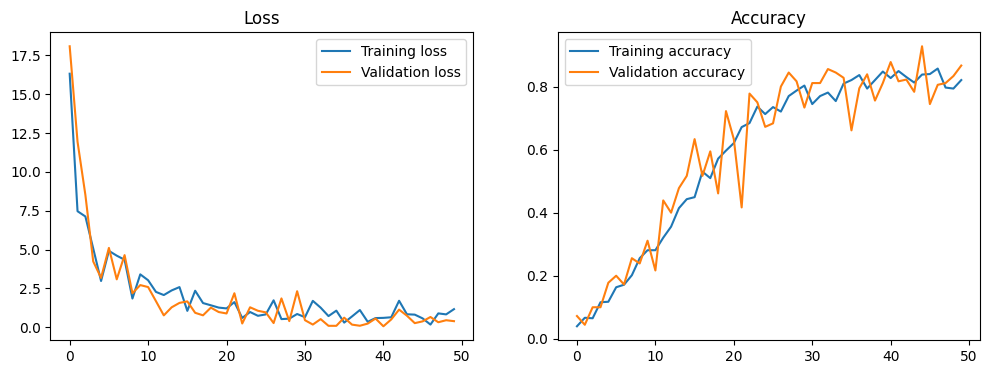

Epoch [51/1100], Loss: 0.18738579750061035, Accuracy: 0.834920634920635 Correct: 526 Total: 630 LR: 0.0004773181818181822 -> 0.0004768645454545458
Validation Accuracy: 0.7333333333333333 Validation loss: 0.2993989586830139 Correct: 132 Total: 180
Epoch [52/1100], Loss: 0.30068832635879517, Accuracy: 0.8936507936507937 Correct: 563 Total: 630 LR: 0.0004768645454545458 -> 0.0004764109090909094
Validation Accuracy: 0.7833333333333333 Validation loss: 1.114527940750122 Correct: 141 Total: 180
Epoch [53/1100], Loss: 0.6712061762809753, Accuracy: 0.8682539682539683 Correct: 547 Total: 630 LR: 0.0004764109090909094 -> 0.00047595727272727305
Validation Accuracy: 0.8555555555555555 Validation loss: 0.7131476402282715 Correct: 154 Total: 180
Epoch [54/1100], Loss: 0.29381874203681946, Accuracy: 0.8380952380952381 Correct: 528 Total: 630 LR: 0.00047595727272727305 -> 0.0004755036363636367
Validation Accuracy: 0.7833333333333333 Validation loss: 1.0336796045303345 Correct: 141 Total: 180
Epoch [55

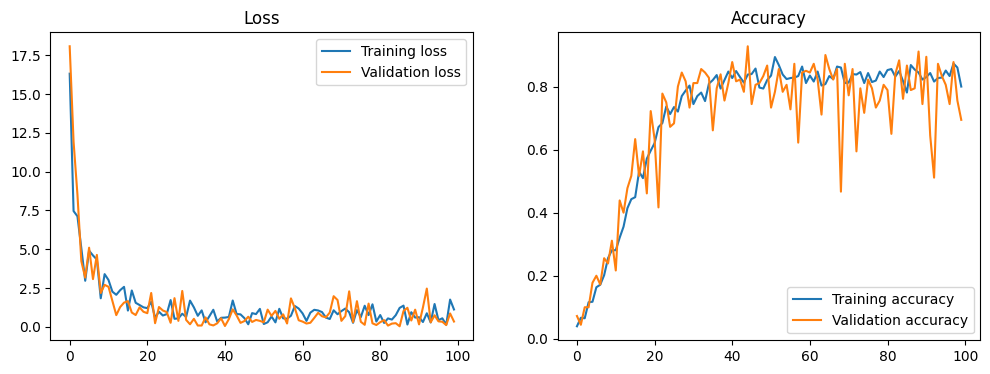

Epoch [101/1100], Loss: 1.0518149137496948, Accuracy: 0.8222222222222222 Correct: 518 Total: 630 LR: 0.0004546363636363642 -> 0.00045418272727272785
Validation Accuracy: 0.85 Validation loss: 0.977853000164032 Correct: 153 Total: 180
Epoch [102/1100], Loss: 0.5150403380393982, Accuracy: 0.8396825396825397 Correct: 529 Total: 630 LR: 0.00045418272727272785 -> 0.0004537290909090915
Validation Accuracy: 0.8666666666666667 Validation loss: 0.7014704942703247 Correct: 156 Total: 180
Epoch [103/1100], Loss: 0.4917517602443695, Accuracy: 0.8412698412698413 Correct: 530 Total: 630 LR: 0.0004537290909090915 -> 0.0004532754545454551
Validation Accuracy: 0.8055555555555556 Validation loss: 0.6150180101394653 Correct: 145 Total: 180
Epoch [104/1100], Loss: 0.46340814232826233, Accuracy: 0.8555555555555555 Correct: 539 Total: 630 LR: 0.0004532754545454551 -> 0.00045282181818181874
Validation Accuracy: 0.8333333333333334 Validation loss: 0.42493903636932373 Correct: 150 Total: 180
Epoch [105/1100], 

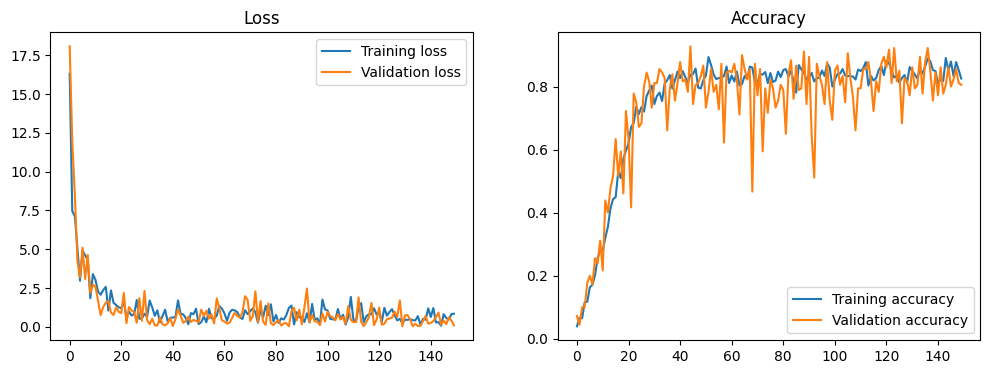

Epoch [151/1100], Loss: 0.6549356579780579, Accuracy: 0.8666666666666667 Correct: 546 Total: 630 LR: 0.0004319545454545459 -> 0.0004315009090909095
Validation Accuracy: 0.8722222222222222 Validation loss: 0.43303924798965454 Correct: 157 Total: 180
Epoch [152/1100], Loss: 0.2205032855272293, Accuracy: 0.8571428571428571 Correct: 540 Total: 630 LR: 0.0004315009090909095 -> 0.0004310472727272731
Validation Accuracy: 0.7833333333333333 Validation loss: 0.41634196043014526 Correct: 141 Total: 180
Epoch [153/1100], Loss: 0.5488529801368713, Accuracy: 0.8063492063492064 Correct: 508 Total: 630 LR: 0.0004310472727272731 -> 0.00043059363636363676
Validation Accuracy: 0.7611111111111111 Validation loss: 1.8376734256744385 Correct: 137 Total: 180
Epoch [154/1100], Loss: 0.4627915322780609, Accuracy: 0.8174603174603174 Correct: 515 Total: 630 LR: 0.00043059363636363676 -> 0.0004301400000000004
Validation Accuracy: 0.8444444444444444 Validation loss: 0.8166647553443909 Correct: 152 Total: 180
Epoc

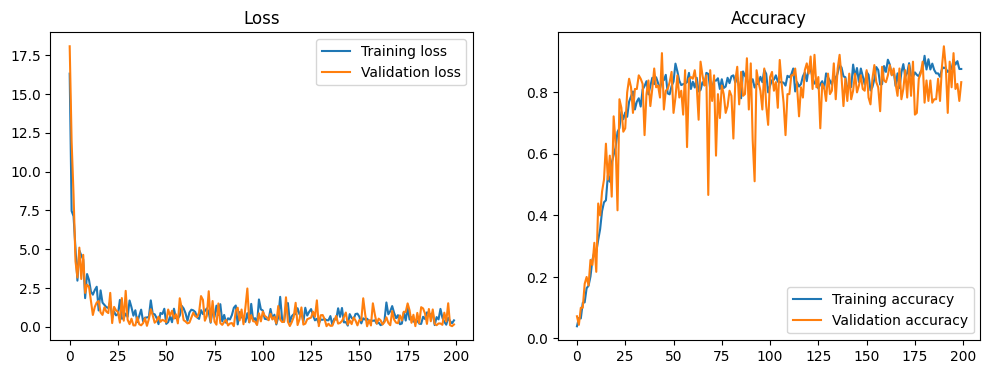

Epoch [201/1100], Loss: 0.6458960175514221, Accuracy: 0.8857142857142857 Correct: 558 Total: 630 LR: 0.00040927272727272774 -> 0.0004088190909090914
Validation Accuracy: 0.8222222222222222 Validation loss: 0.7036417722702026 Correct: 148 Total: 180
Epoch [202/1100], Loss: 0.8922435641288757, Accuracy: 0.8698412698412699 Correct: 548 Total: 630 LR: 0.0004088190909090914 -> 0.00040836545454545504
Validation Accuracy: 0.8222222222222222 Validation loss: 0.19408302009105682 Correct: 148 Total: 180
Epoch [203/1100], Loss: 1.4427293539047241, Accuracy: 0.8888888888888888 Correct: 560 Total: 630 LR: 0.00040836545454545504 -> 0.0004079118181818187
Validation Accuracy: 0.8944444444444445 Validation loss: 0.6065596342086792 Correct: 161 Total: 180
Epoch [204/1100], Loss: 0.5239414572715759, Accuracy: 0.8428571428571429 Correct: 531 Total: 630 LR: 0.0004079118181818187 -> 0.00040745818181818234
Validation Accuracy: 0.8 Validation loss: 0.15407362580299377 Correct: 144 Total: 180
Epoch [205/1100],

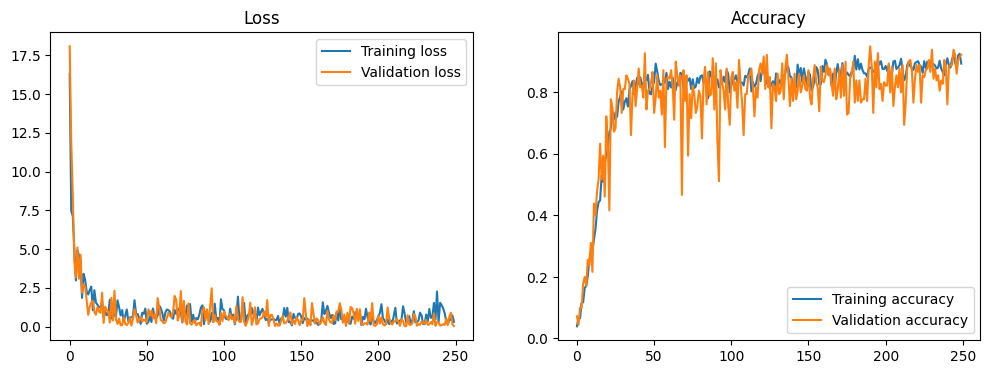

Epoch [251/1100], Loss: 0.5693025588989258, Accuracy: 0.9079365079365079 Correct: 572 Total: 630 LR: 0.00038659090909090983 -> 0.0003861372727272735
Validation Accuracy: 0.8388888888888889 Validation loss: 0.8881523013114929 Correct: 151 Total: 180
Epoch [252/1100], Loss: 0.4851655066013336, Accuracy: 0.873015873015873 Correct: 550 Total: 630 LR: 0.0003861372727272735 -> 0.00038568363636363713
Validation Accuracy: 0.7944444444444444 Validation loss: 0.3621036410331726 Correct: 143 Total: 180
Epoch [253/1100], Loss: 1.0319429636001587, Accuracy: 0.8952380952380953 Correct: 564 Total: 630 LR: 0.00038568363636363713 -> 0.0003852300000000008
Validation Accuracy: 0.9111111111111111 Validation loss: 0.021285364404320717 Correct: 164 Total: 180
Epoch [254/1100], Loss: 0.9335082173347473, Accuracy: 0.9031746031746032 Correct: 569 Total: 630 LR: 0.0003852300000000008 -> 0.00038477636363636443
Validation Accuracy: 0.9111111111111111 Validation loss: 0.39430317282676697 Correct: 164 Total: 180
Ep

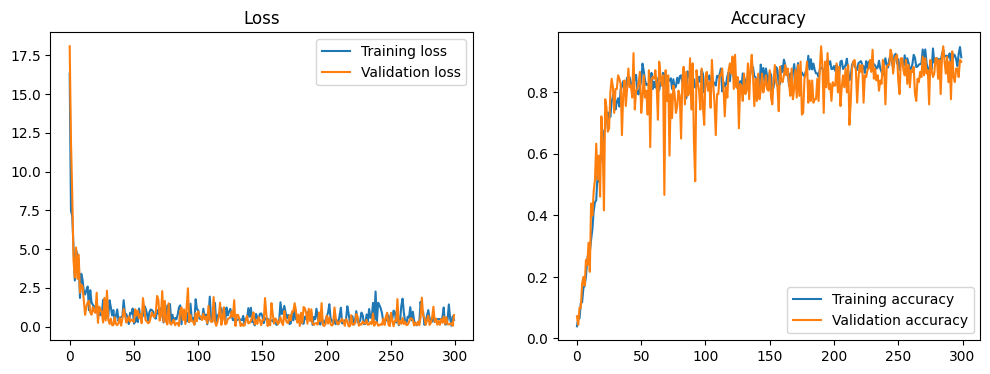

Epoch [301/1100], Loss: 0.0986476019024849, Accuracy: 0.8920634920634921 Correct: 562 Total: 630 LR: 0.0003639090909090916 -> 0.00036345545454545525
Validation Accuracy: 0.9111111111111111 Validation loss: 0.05991600453853607 Correct: 164 Total: 180
Epoch [302/1100], Loss: 0.16898803412914276, Accuracy: 0.9317460317460318 Correct: 587 Total: 630 LR: 0.00036345545454545525 -> 0.0003630018181818189
Validation Accuracy: 0.8166666666666667 Validation loss: 0.20438438653945923 Correct: 147 Total: 180
Epoch [303/1100], Loss: 0.2801385223865509, Accuracy: 0.9396825396825397 Correct: 592 Total: 630 LR: 0.0003630018181818189 -> 0.00036254818181818255
Validation Accuracy: 0.8555555555555555 Validation loss: 1.4289913177490234 Correct: 154 Total: 180
Epoch [304/1100], Loss: 0.09069982916116714, Accuracy: 0.9317460317460318 Correct: 587 Total: 630 LR: 0.00036254818181818255 -> 0.0003620945454545462
Validation Accuracy: 0.9 Validation loss: 0.15098775923252106 Correct: 162 Total: 180
Epoch [305/110

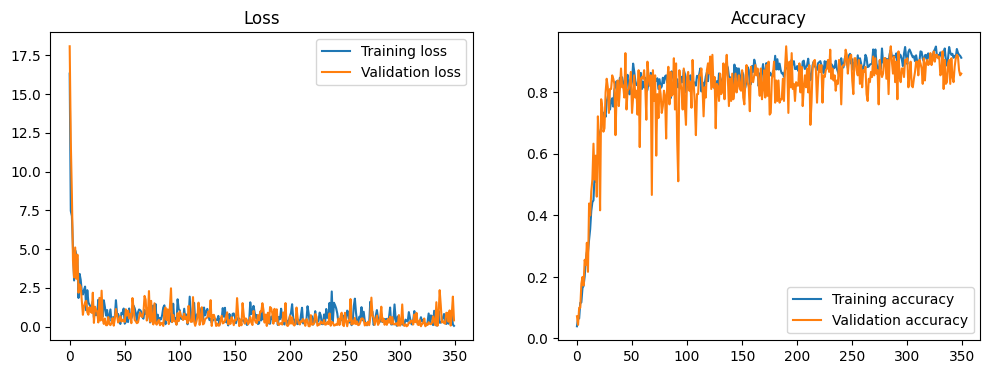

Epoch [351/1100], Loss: 0.16442836821079254, Accuracy: 0.9396825396825397 Correct: 592 Total: 630 LR: 0.0003412272727272734 -> 0.000340773636363637
Validation Accuracy: 0.8944444444444445 Validation loss: 0.33484357595443726 Correct: 161 Total: 180
Epoch [352/1100], Loss: 0.16655443608760834, Accuracy: 0.9365079365079365 Correct: 590 Total: 630 LR: 0.000340773636363637 -> 0.00034032000000000067
Validation Accuracy: 0.8444444444444444 Validation loss: 0.03035968914628029 Correct: 152 Total: 180
Epoch [353/1100], Loss: 0.24612243473529816, Accuracy: 0.9063492063492063 Correct: 571 Total: 630 LR: 0.00034032000000000067 -> 0.0003398663636363643
Validation Accuracy: 0.9444444444444444 Validation loss: 0.2531736493110657 Correct: 170 Total: 180
Epoch [354/1100], Loss: 0.22844256460666656, Accuracy: 0.9206349206349206 Correct: 580 Total: 630 LR: 0.0003398663636363643 -> 0.00033941272727272797
Validation Accuracy: 0.8722222222222222 Validation loss: 0.089768186211586 Correct: 157 Total: 180
Ep

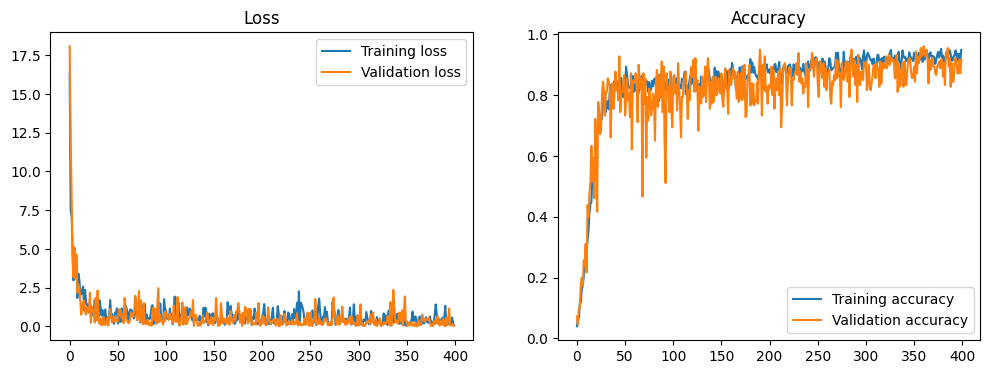

Epoch [401/1100], Loss: 0.7465831637382507, Accuracy: 0.9380952380952381 Correct: 591 Total: 630 LR: 0.00031854545454545547 -> 0.0003180918181818191
Validation Accuracy: 0.9166666666666666 Validation loss: 0.3553948998451233 Correct: 165 Total: 180
Epoch [402/1100], Loss: 0.19142784178256989, Accuracy: 0.9333333333333333 Correct: 588 Total: 630 LR: 0.0003180918181818191 -> 0.00031763818181818277
Validation Accuracy: 0.9222222222222223 Validation loss: 0.056163907051086426 Correct: 166 Total: 180
Epoch [403/1100], Loss: 0.0455588661134243, Accuracy: 0.9285714285714286 Correct: 585 Total: 630 LR: 0.00031763818181818277 -> 0.0003171845454545464
Validation Accuracy: 0.95 Validation loss: 0.08914214372634888 Correct: 171 Total: 180
Epoch [404/1100], Loss: 0.5897394418716431, Accuracy: 0.9333333333333333 Correct: 588 Total: 630 LR: 0.0003171845454545464 -> 0.00031673090909091007
Validation Accuracy: 0.8777777777777778 Validation loss: 0.09258536249399185 Correct: 158 Total: 180
Epoch [405/11

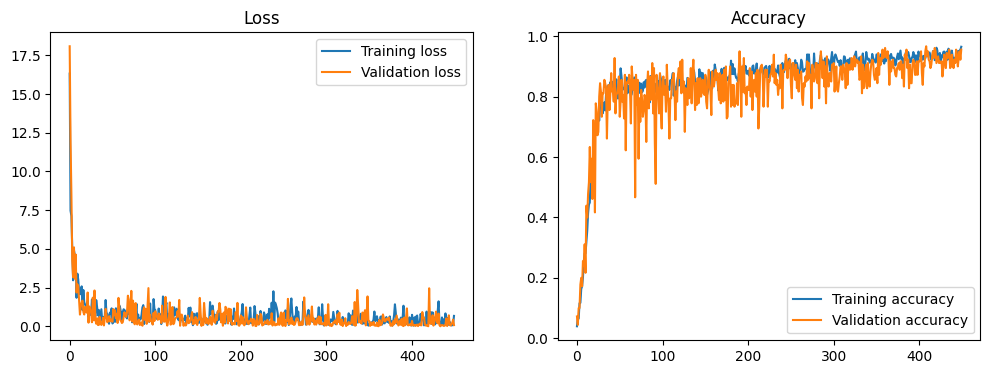

Epoch [451/1100], Loss: 0.56300950050354, Accuracy: 0.9444444444444444 Correct: 595 Total: 630 LR: 0.00029586363636363735 -> 0.000295410000000001
Validation Accuracy: 0.8555555555555555 Validation loss: 0.38709548115730286 Correct: 154 Total: 180
Epoch [452/1100], Loss: 0.09556909650564194, Accuracy: 0.9174603174603174 Correct: 578 Total: 630 LR: 0.000295410000000001 -> 0.00029495636363636464
Validation Accuracy: 0.9055555555555556 Validation loss: 0.48673704266548157 Correct: 163 Total: 180
Epoch [453/1100], Loss: 0.25808897614479065, Accuracy: 0.946031746031746 Correct: 596 Total: 630 LR: 0.00029495636363636464 -> 0.0002945027272727283
Validation Accuracy: 0.9277777777777778 Validation loss: 0.2429128736257553 Correct: 167 Total: 180
Epoch [454/1100], Loss: 0.13956886529922485, Accuracy: 0.9523809523809523 Correct: 600 Total: 630 LR: 0.0002945027272727283 -> 0.00029404909090909194
Validation Accuracy: 0.9277777777777778 Validation loss: 0.12805438041687012 Correct: 167 Total: 180
Epo

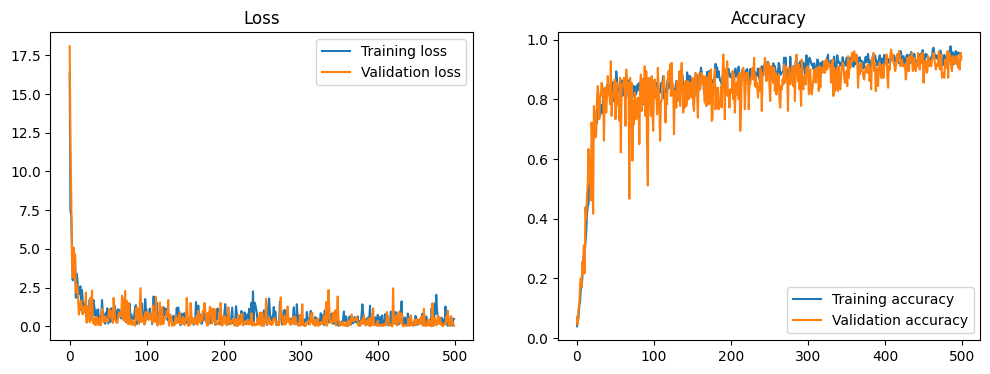

Epoch [501/1100], Loss: 0.21186482906341553, Accuracy: 0.9444444444444444 Correct: 595 Total: 630 LR: 0.00027318181818181977 -> 0.0002727281818181834
Validation Accuracy: 0.8944444444444445 Validation loss: 1.0756703615188599 Correct: 161 Total: 180
Epoch [502/1100], Loss: 0.38971754908561707, Accuracy: 0.9571428571428572 Correct: 603 Total: 630 LR: 0.0002727281818181834 -> 0.00027227454545454706
Validation Accuracy: 0.95 Validation loss: 0.15664497017860413 Correct: 171 Total: 180
Epoch [503/1100], Loss: 0.05638812109827995, Accuracy: 0.9587301587301588 Correct: 604 Total: 630 LR: 0.00027227454545454706 -> 0.0002718209090909107
Validation Accuracy: 0.9111111111111111 Validation loss: 0.4508705139160156 Correct: 164 Total: 180
Epoch [504/1100], Loss: 0.4851178228855133, Accuracy: 0.9507936507936507 Correct: 599 Total: 630 LR: 0.0002718209090909107 -> 0.00027136727272727436
Validation Accuracy: 0.9444444444444444 Validation loss: 0.14126908779144287 Correct: 170 Total: 180
Epoch [505/11

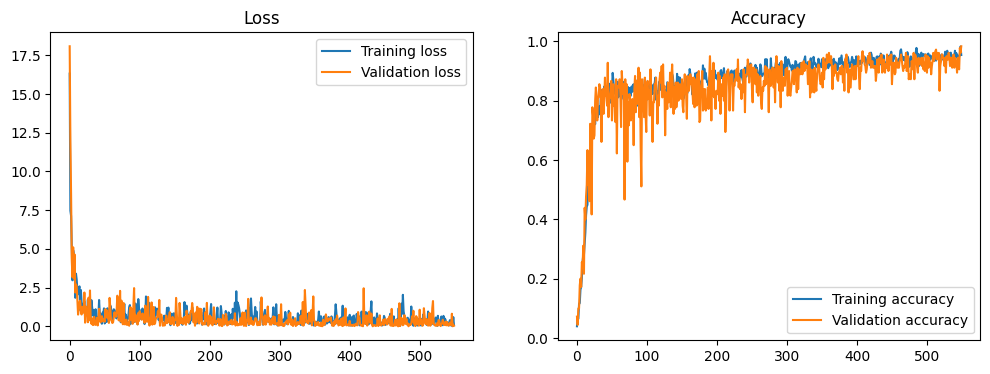

Epoch [551/1100], Loss: 0.4014502763748169, Accuracy: 0.9634920634920635 Correct: 607 Total: 630 LR: 0.000250500000000002 -> 0.00025004636363636567
Validation Accuracy: 0.9444444444444444 Validation loss: 0.02229856327176094 Correct: 170 Total: 180
Epoch [552/1100], Loss: 0.9582901000976562, Accuracy: 0.9507936507936507 Correct: 599 Total: 630 LR: 0.00025004636363636567 -> 0.0002495927272727293
Validation Accuracy: 0.9833333333333333 Validation loss: 0.02714952826499939 Correct: 177 Total: 180
Epoch [553/1100], Loss: 0.055607859045267105, Accuracy: 0.9349206349206349 Correct: 589 Total: 630 LR: 0.0002495927272727293 -> 0.00024913909090909297
Validation Accuracy: 0.9222222222222223 Validation loss: 0.03602956607937813 Correct: 166 Total: 180
Epoch [554/1100], Loss: 0.01301893312484026, Accuracy: 0.9634920634920635 Correct: 607 Total: 630 LR: 0.00024913909090909297 -> 0.00024868545454545657
Validation Accuracy: 0.8944444444444445 Validation loss: 0.25144678354263306 Correct: 161 Total: 1

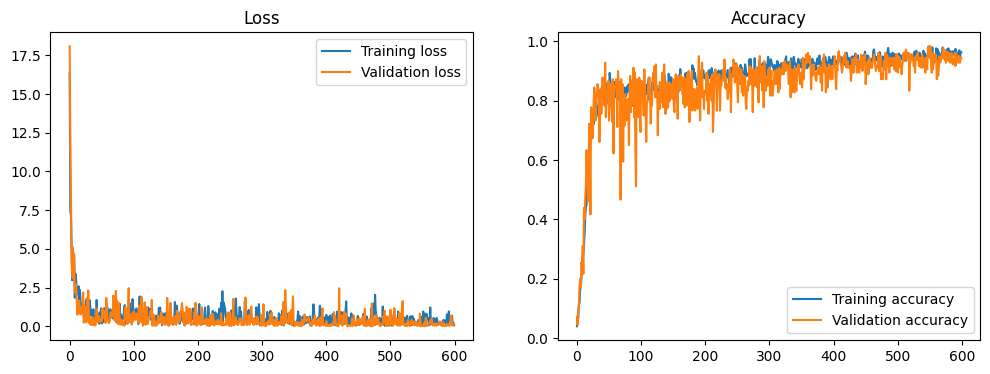

Epoch [601/1100], Loss: 0.047135621309280396, Accuracy: 0.9761904761904762 Correct: 615 Total: 630 LR: 0.00022781818181818385 -> 0.00022736454545454747
Validation Accuracy: 0.95 Validation loss: 0.030468884855508804 Correct: 171 Total: 180
Epoch [602/1100], Loss: 0.06259877979755402, Accuracy: 0.9666666666666667 Correct: 609 Total: 630 LR: 0.00022736454545454747 -> 0.0002269109090909111
Validation Accuracy: 0.95 Validation loss: 0.06225566938519478 Correct: 171 Total: 180
Epoch [603/1100], Loss: 0.25336214900016785, Accuracy: 0.9619047619047619 Correct: 606 Total: 630 LR: 0.0002269109090909111 -> 0.00022645727272727471
Validation Accuracy: 0.95 Validation loss: 0.1426219940185547 Correct: 171 Total: 180
Epoch [604/1100], Loss: 0.46045517921447754, Accuracy: 0.9666666666666667 Correct: 609 Total: 630 LR: 0.00022645727272727471 -> 0.00022600363636363834
Validation Accuracy: 0.9222222222222223 Validation loss: 0.43957534432411194 Correct: 166 Total: 180
Epoch [605/1100], Loss: 0.148952707

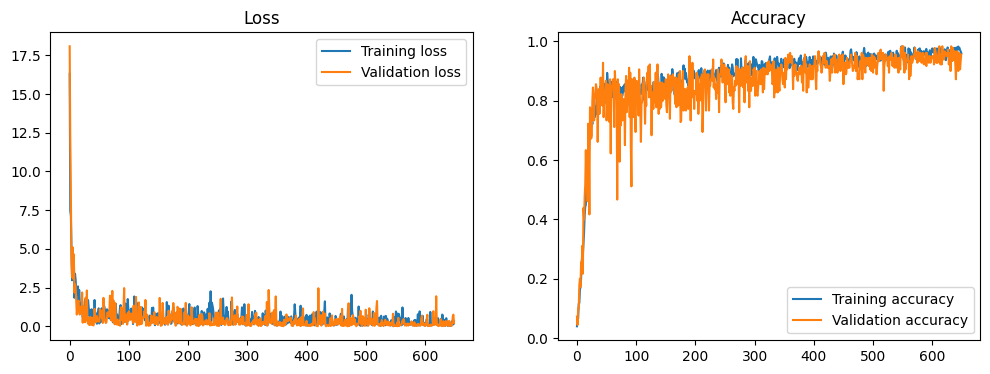

Epoch [651/1100], Loss: 0.4439811408519745, Accuracy: 0.9492063492063492 Correct: 598 Total: 630 LR: 0.0002051363636363653 -> 0.0002046827272727289
Validation Accuracy: 0.9 Validation loss: 0.04024941474199295 Correct: 162 Total: 180
Epoch [652/1100], Loss: 0.34769687056541443, Accuracy: 0.9650793650793651 Correct: 608 Total: 630 LR: 0.0002046827272727289 -> 0.00020422909090909256
Validation Accuracy: 0.9111111111111111 Validation loss: 0.11690913140773773 Correct: 164 Total: 180
Epoch [653/1100], Loss: 0.3091993033885956, Accuracy: 0.9714285714285714 Correct: 612 Total: 630 LR: 0.00020422909090909256 -> 0.0002037754545454562
Validation Accuracy: 0.9555555555555556 Validation loss: 0.0063681709580123425 Correct: 172 Total: 180
Epoch [654/1100], Loss: 0.7587759494781494, Accuracy: 0.9746031746031746 Correct: 614 Total: 630 LR: 0.0002037754545454562 -> 0.00020332181818181986
Validation Accuracy: 0.95 Validation loss: 0.3123728036880493 Correct: 171 Total: 180
Epoch [655/1100], Loss: 0.43

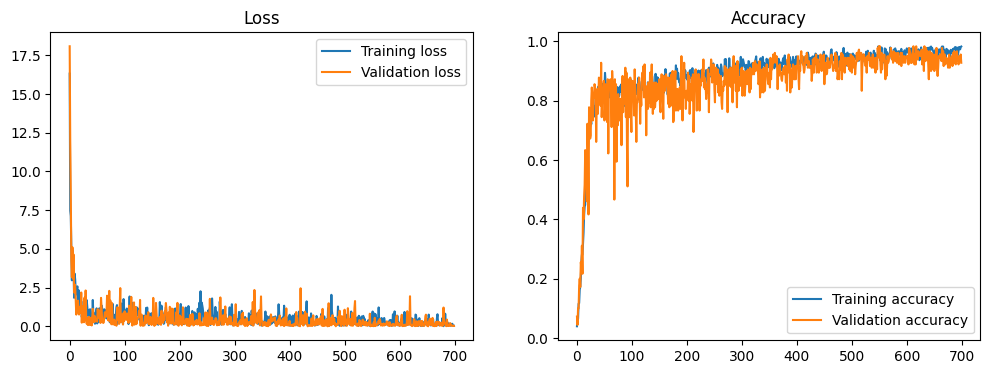

Epoch [701/1100], Loss: 0.1827949732542038, Accuracy: 0.9634920634920635 Correct: 607 Total: 630 LR: 0.000182454545454547 -> 0.00018200090909091066
Validation Accuracy: 0.9611111111111111 Validation loss: 0.053669292479753494 Correct: 173 Total: 180
Epoch [702/1100], Loss: 0.070767842233181, Accuracy: 0.9698412698412698 Correct: 611 Total: 630 LR: 0.00018200090909091066 -> 0.0001815472727272743
Validation Accuracy: 0.9166666666666666 Validation loss: 0.13424120843410492 Correct: 165 Total: 180
Epoch [703/1100], Loss: 0.5480068325996399, Accuracy: 0.9571428571428572 Correct: 603 Total: 630 LR: 0.0001815472727272743 -> 0.00018109363636363793
Validation Accuracy: 0.9444444444444444 Validation loss: 0.5125645399093628 Correct: 170 Total: 180
Epoch [704/1100], Loss: 0.9735304713249207, Accuracy: 0.9555555555555556 Correct: 602 Total: 630 LR: 0.00018109363636363793 -> 0.00018064000000000155
Validation Accuracy: 0.9611111111111111 Validation loss: 0.1580684781074524 Correct: 173 Total: 180
Ep

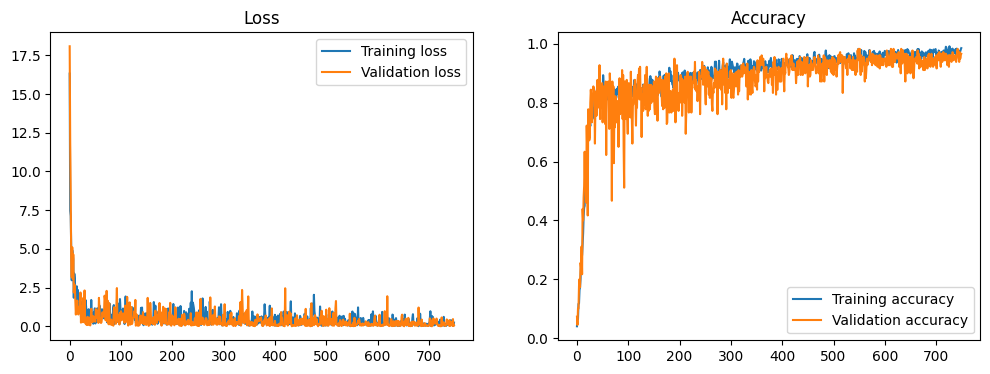

Epoch [751/1100], Loss: 0.12454680353403091, Accuracy: 0.9634920634920635 Correct: 607 Total: 630 LR: 0.0001597727272727286 -> 0.00015931909090909224
Validation Accuracy: 0.9444444444444444 Validation loss: 0.10848235338926315 Correct: 170 Total: 180
Epoch [752/1100], Loss: 0.15401297807693481, Accuracy: 0.9809523809523809 Correct: 618 Total: 630 LR: 0.00015931909090909224 -> 0.00015886545454545589
Validation Accuracy: 0.9611111111111111 Validation loss: 0.2686222791671753 Correct: 173 Total: 180
Epoch [753/1100], Loss: 0.09639876335859299, Accuracy: 0.953968253968254 Correct: 601 Total: 630 LR: 0.00015886545454545589 -> 0.0001584118181818195
Validation Accuracy: 0.9388888888888889 Validation loss: 0.11413027346134186 Correct: 169 Total: 180
Epoch [754/1100], Loss: 0.21691568195819855, Accuracy: 0.9698412698412698 Correct: 611 Total: 630 LR: 0.0001584118181818195 -> 0.00015795818181818313
Validation Accuracy: 0.95 Validation loss: 0.2015867978334427 Correct: 171 Total: 180
Epoch [755/1

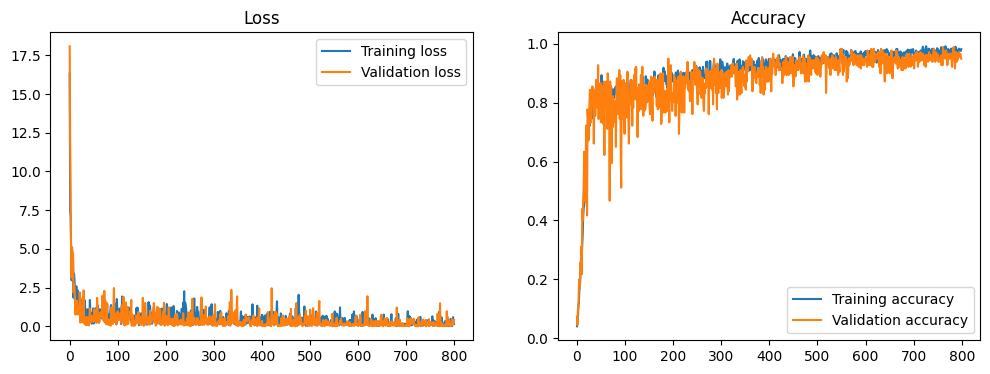

Epoch [801/1100], Loss: 0.05338064953684807, Accuracy: 0.9857142857142858 Correct: 621 Total: 630 LR: 0.00013709090909091036 -> 0.000136637272727274
Validation Accuracy: 0.9833333333333333 Validation loss: 0.1613544374704361 Correct: 177 Total: 180
Epoch [802/1100], Loss: 0.05133570358157158, Accuracy: 0.9825396825396825 Correct: 619 Total: 630 LR: 0.000136637272727274 -> 0.00013618363636363765
Validation Accuracy: 0.9722222222222222 Validation loss: 0.2989075183868408 Correct: 175 Total: 180
Epoch [803/1100], Loss: 0.015449821949005127, Accuracy: 0.9873015873015873 Correct: 622 Total: 630 LR: 0.00013618363636363765 -> 0.00013573000000000128
Validation Accuracy: 0.9888888888888889 Validation loss: 0.16036872565746307 Correct: 178 Total: 180
Epoch [804/1100], Loss: 0.027985451743006706, Accuracy: 0.9904761904761905 Correct: 624 Total: 630 LR: 0.00013573000000000128 -> 0.0001352763636363649
Validation Accuracy: 0.9666666666666667 Validation loss: 0.009793752804398537 Correct: 174 Total: 

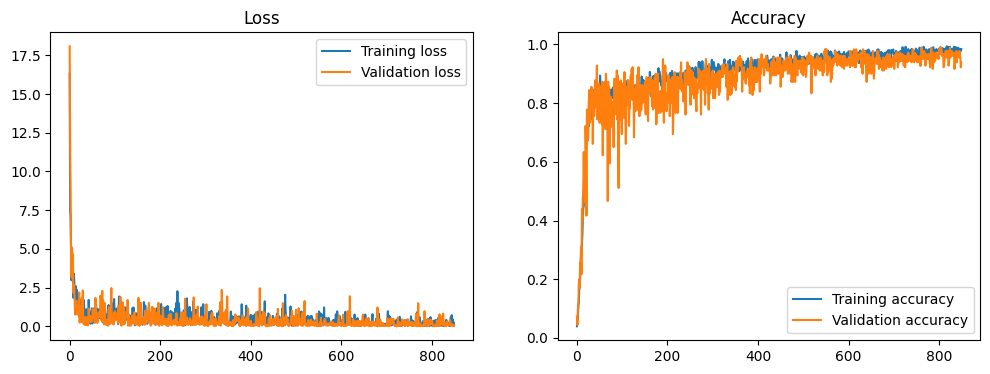

Epoch [851/1100], Loss: 0.49412012100219727, Accuracy: 0.9825396825396825 Correct: 619 Total: 630 LR: 0.00011440909090909198 -> 0.00011395545454545561
Validation Accuracy: 0.9611111111111111 Validation loss: 0.24513877928256989 Correct: 173 Total: 180
Epoch [852/1100], Loss: 0.1819922924041748, Accuracy: 0.9841269841269841 Correct: 620 Total: 630 LR: 0.00011395545454545561 -> 0.00011350181818181925
Validation Accuracy: 0.9777777777777777 Validation loss: 0.0974903553724289 Correct: 176 Total: 180
Epoch [853/1100], Loss: 0.04813092574477196, Accuracy: 0.9857142857142858 Correct: 621 Total: 630 LR: 0.00011350181818181925 -> 0.00011304818181818287
Validation Accuracy: 0.9777777777777777 Validation loss: 0.27119866013526917 Correct: 176 Total: 180
Epoch [854/1100], Loss: 0.027722192928195, Accuracy: 0.9888888888888889 Correct: 623 Total: 630 LR: 0.00011304818181818287 -> 0.0001125945454545465
Validation Accuracy: 0.9666666666666667 Validation loss: 0.06578194350004196 Correct: 174 Total: 1

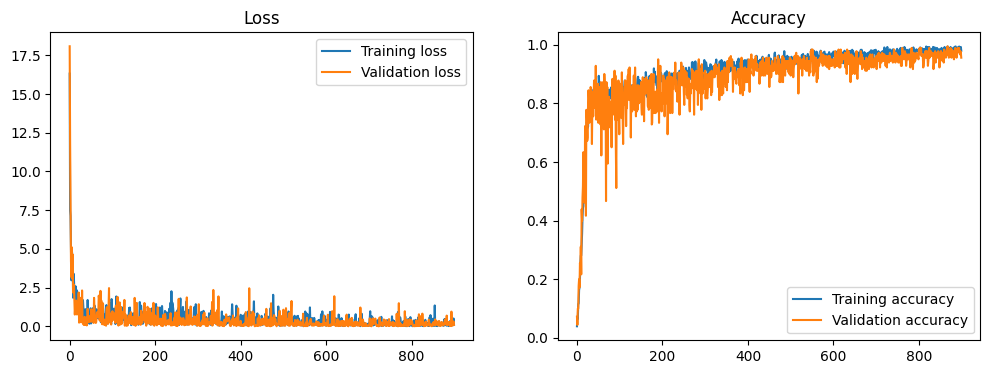

Epoch [901/1100], Loss: 0.07058196514844894, Accuracy: 0.9888888888888889 Correct: 623 Total: 630 LR: 9.172727272727361e-05 -> 9.127363636363725e-05
Validation Accuracy: 0.9555555555555556 Validation loss: 0.2481382191181183 Correct: 172 Total: 180
Epoch [902/1100], Loss: 0.16126661002635956, Accuracy: 0.9936507936507937 Correct: 626 Total: 630 LR: 9.127363636363725e-05 -> 9.082000000000088e-05
Validation Accuracy: 0.95 Validation loss: 0.3877445161342621 Correct: 171 Total: 180
Epoch [903/1100], Loss: 0.036028724163770676, Accuracy: 0.9857142857142858 Correct: 621 Total: 630 LR: 9.082000000000088e-05 -> 9.036636363636452e-05
Validation Accuracy: 0.9444444444444444 Validation loss: 0.21831096708774567 Correct: 170 Total: 180
Epoch [904/1100], Loss: 0.13438516855239868, Accuracy: 0.9825396825396825 Correct: 619 Total: 630 LR: 9.036636363636452e-05 -> 8.991272727272815e-05
Validation Accuracy: 0.9666666666666667 Validation loss: 0.03441771864891052 Correct: 174 Total: 180
Epoch [905/1100

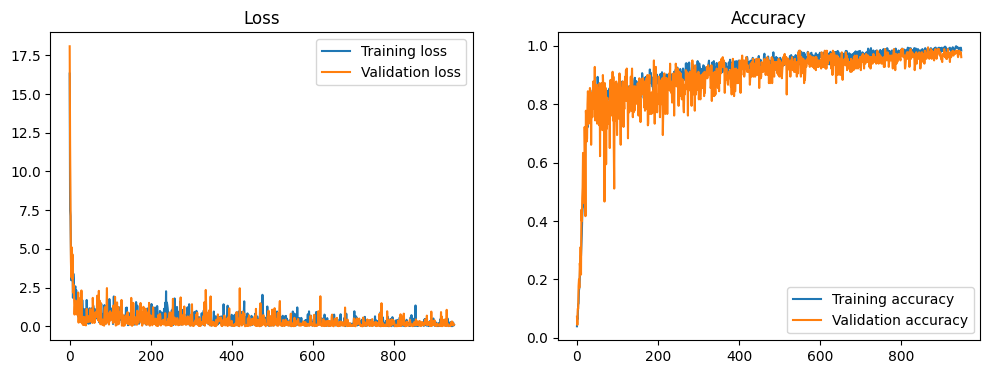

Epoch [951/1100], Loss: 0.05516338348388672, Accuracy: 0.9984126984126984 Correct: 629 Total: 630 LR: 6.904545454545533e-05 -> 6.859181818181895e-05
Validation Accuracy: 0.9722222222222222 Validation loss: 0.3808515965938568 Correct: 175 Total: 180
Epoch [952/1100], Loss: 0.19772373139858246, Accuracy: 0.9888888888888889 Correct: 623 Total: 630 LR: 6.859181818181895e-05 -> 6.813818181818258e-05
Validation Accuracy: 0.9666666666666667 Validation loss: 0.22041554749011993 Correct: 174 Total: 180
Epoch [953/1100], Loss: 0.3818334639072418, Accuracy: 0.9825396825396825 Correct: 619 Total: 630 LR: 6.813818181818258e-05 -> 6.768454545454622e-05
Validation Accuracy: 0.9444444444444444 Validation loss: 0.20811310410499573 Correct: 170 Total: 180
Epoch [954/1100], Loss: 0.23594652116298676, Accuracy: 0.9968253968253968 Correct: 628 Total: 630 LR: 6.768454545454622e-05 -> 6.723090909090986e-05
Validation Accuracy: 0.9611111111111111 Validation loss: 0.016141286119818687 Correct: 173 Total: 180
E

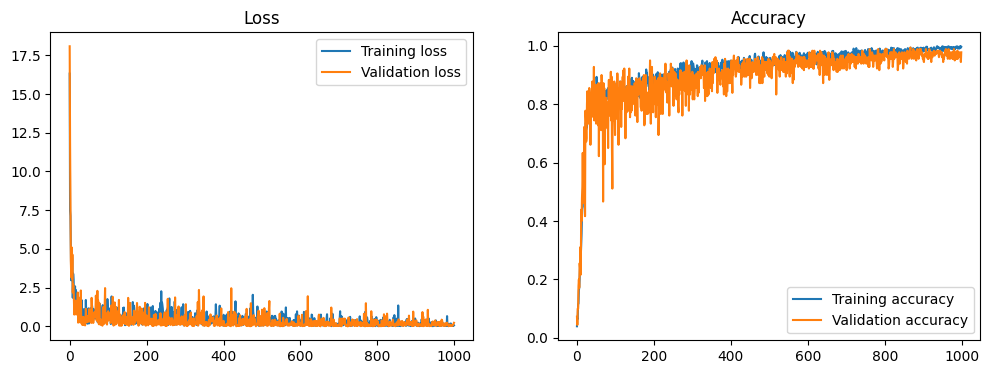

Epoch [1001/1100], Loss: 0.20737893879413605, Accuracy: 0.9936507936507937 Correct: 626 Total: 630 LR: 4.6363636363636885e-05 -> 4.591000000000052e-05
Validation Accuracy: 0.9777777777777777 Validation loss: 0.04884586110711098 Correct: 176 Total: 180
Epoch [1002/1100], Loss: 0.18266738951206207, Accuracy: 0.9888888888888889 Correct: 623 Total: 630 LR: 4.591000000000052e-05 -> 4.545636363636415e-05
Validation Accuracy: 0.9611111111111111 Validation loss: 0.02497055009007454 Correct: 173 Total: 180
Epoch [1003/1100], Loss: 0.08179987221956253, Accuracy: 0.9920634920634921 Correct: 625 Total: 630 LR: 4.545636363636415e-05 -> 4.500272727272778e-05
Validation Accuracy: 0.9722222222222222 Validation loss: 0.23193877935409546 Correct: 175 Total: 180
Epoch [1004/1100], Loss: 0.03491552919149399, Accuracy: 0.9984126984126984 Correct: 629 Total: 630 LR: 4.500272727272778e-05 -> 4.4549090909091415e-05
Validation Accuracy: 0.9777777777777777 Validation loss: 0.01596614345908165 Correct: 176 Total

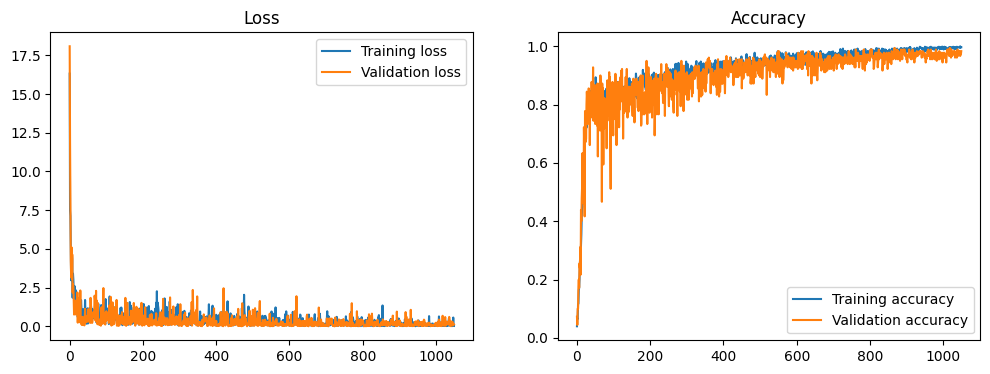

Epoch [1051/1100], Loss: 0.04359365627169609, Accuracy: 0.9968253968253968 Correct: 628 Total: 630 LR: 2.3681818181818428e-05 -> 2.322818181818206e-05
Validation Accuracy: 0.9833333333333333 Validation loss: 0.22156934440135956 Correct: 177 Total: 180
Epoch [1052/1100], Loss: 0.053854282945394516, Accuracy: 0.9952380952380953 Correct: 627 Total: 630 LR: 2.322818181818206e-05 -> 2.2774545454545693e-05
Validation Accuracy: 0.9777777777777777 Validation loss: 0.16234725713729858 Correct: 176 Total: 180
Epoch [1053/1100], Loss: 0.24987514317035675, Accuracy: 0.9952380952380953 Correct: 627 Total: 630 LR: 2.2774545454545693e-05 -> 2.2320909090909325e-05
Validation Accuracy: 0.9888888888888889 Validation loss: 0.4660077691078186 Correct: 178 Total: 180
Epoch [1054/1100], Loss: 0.032547514885663986, Accuracy: 0.9952380952380953 Correct: 627 Total: 630 LR: 2.2320909090909325e-05 -> 2.1867272727272958e-05
Validation Accuracy: 0.9833333333333333 Validation loss: 0.035031165927648544 Correct: 177

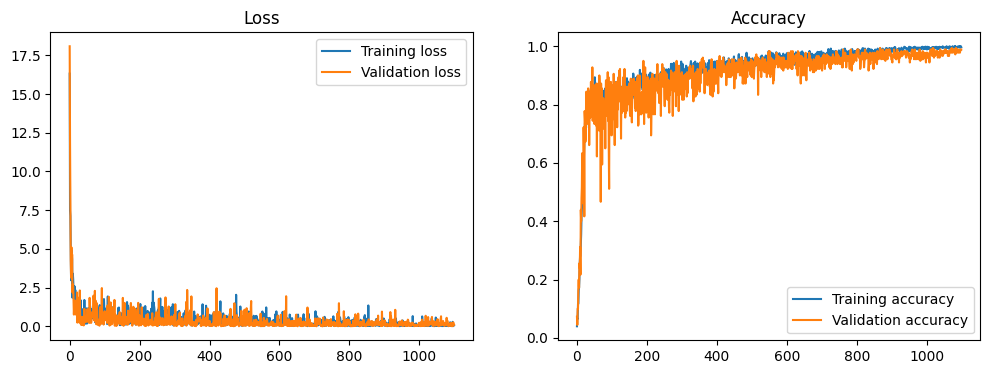

In [28]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
        model.train()
        correct = 0
        total = 0
        for inputs, labels in train_dataloader:
            inputs = inputs.to(device)
            labels = torch.squeeze(labels).to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = cost(outputs, torch.squeeze(labels))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss.backward()
            optimizer.step()
        
        previous_lr = scheduler.get_last_lr()[0]
        scheduler.step()
        next_lr = scheduler.get_last_lr()[0]
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}, Accuracy: {correct/total}", "Correct:", correct, "Total:", total, f"LR: {previous_lr} -> {next_lr}")
        train_losses.append(loss.item())
        train_accuracies.append(correct/total)

        # Validation
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for inputs, labels in val_dataloader:
                inputs = inputs.to(device)
                labels = torch.squeeze(labels).to(device)
                outputs = model(inputs)
                
                loss = cost(outputs, torch.squeeze(labels))
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            print(f"Validation Accuracy: {correct/total}", f"Validation loss: {loss}", "Correct:", correct, "Total:", total)
            val_losses.append(loss.item())
            val_accuracies.append(correct/total)
        
        if epoch != 0 and (epoch % 50 == 49):
            plot_results(train_losses, train_accuracies, val_losses, val_accuracies)
        if epoch > 2 and val_accuracies[-1] > max(val_accuracies[:-1]):
            save_model(model, best_model_path)

In [29]:
save_model(model, model_path)

### Results

In [30]:
model.load_state_dict(torch.load(best_model_path))
model.to(device)
model.eval()

MyCoAtNet(
  (0): Sequential(
    (0): Stem(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    )
  )
  (1): Sequential(
    (0): DownsamplingMBConv(
      (mb_conv): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Conv2d(64, 256, kernel_size=(1, 1), stride=(2, 2))
        (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): GELU(approximate='none')
        (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=256)
        (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): GELU(approximate='none')
        (7): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
    

In [31]:
print("Best validation acc: ", max(val_accuracies))
print("Last validation acc: ", val_accuracies[-1])

Best validation acc:  0.9944444444444445
Last validation acc:  0.9888888888888889


In [32]:
# Generate the alphabet (0-9 and A-Z)
digits = [str(digit) for digit in range(10)]
alphabet = [chr(ascii_code) for ascii_code in range(ord('A'), ord('Z') + 1)]

# Combine digits and alphabet
all_characters = digits + alphabet

# Create the label dictionary
label_dict = {i: all_characters[i] for i in range(len(all_characters))}

# Print the label dictionary
print(label_dict)


{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z'}


In [33]:
# Adapted from My_CoAtNet
predictions_path = 'predictions-zoom.csv'

def predict(data_loader):

    original_labels = []
    predicted_labels = []

    correct = 0
    total = 0
    
    model.eval()
    
    for inputs, labels in data_loader:

        inputs = inputs.to(device)
        labels = torch.squeeze(labels).to(device)
        outputs = model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
      
        original_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    prediction_df = pd.DataFrame({"predicted_labels": [label_dict[pred] for pred in predicted_labels], "true_labels": [label_dict[label] for label in original_labels]})
    prediction_df.to_csv(predictions_path)

    print(f"Test Accuracy: {correct/total}")
    pd.set_option('display.max_rows', None)
    pd.set_option("display.max_columns", None)
    display(prediction_df.T)
    
    print (metrics.accuracy_score(original_labels, predicted_labels))
    print (metrics.classification_report(original_labels, predicted_labels))
    
    return confusion_matrix(original_labels, predicted_labels)

### Test accuracy

In [34]:
cm = predict(test_dataloader)

Test Accuracy: 0.9555555555555556


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89
predicted_labels,Z,K,8,Y,S,0,9,R,D,F,U,1,1,E,Z,C,5,0,R,K,L,I,G,B,8,M,O,9,2,4,7,D,L,L,N,F,D,N,Q,3,P,V,7,Q,U,T,V,X,Z,S,K,3,X,Y,W,I,X,S,B,R,H,M,I,T,6,P,X,5,J,G,S,2,B,6,N,3,Y,9,M,H,E,A,G,R,4,4,S,O,J,J
true_labels,Z,K,8,Y,W,0,9,R,D,F,U,1,1,E,Z,C,5,0,R,K,L,I,G,B,8,M,O,9,2,4,7,D,L,L,N,F,D,N,Q,3,P,V,7,Q,U,T,V,X,Z,S,K,3,X,Y,W,I,X,S,B,5,H,M,I,T,6,P,C,5,J,G,S,2,B,6,N,3,Y,9,M,H,E,A,G,R,4,4,A,O,J,J


0.9555555555555556
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         3
           5       1.00      0.67      0.80         3
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         3
          10       1.00      0.50      0.67         2
          11       1.00      1.00      1.00         3
          12       1.00      0.50      0.67         2
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         2
          16       1.00      1.00      1.00         3
        

### Confusion matrix

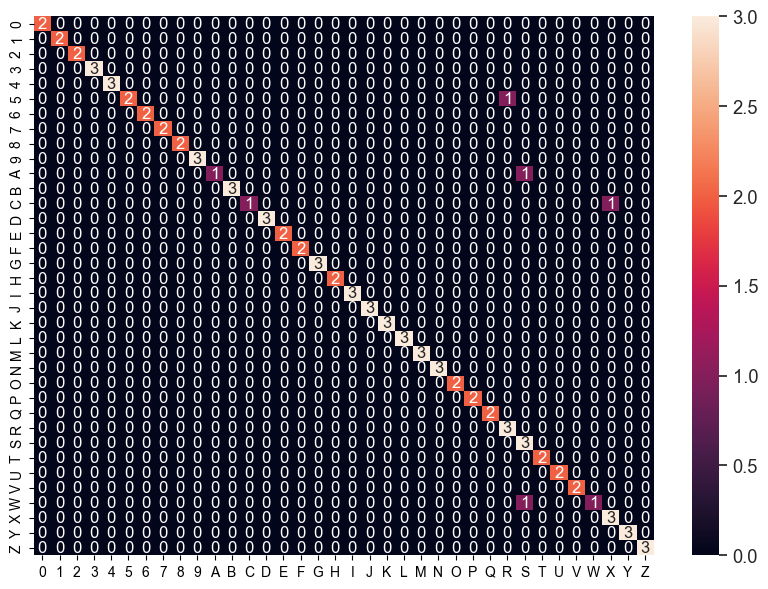

In [35]:
fig, ax = plt.subplots(figsize=(10,7))
sns.set(font_scale=1.2)
ax = sns.heatmap(cm,
                annot=True,
                fmt='g',
                xticklabels=all_characters, 
                yticklabels=all_characters,
                annot_kws={"size": 12}
                )
fig.savefig("confusion_matrix_CoAtNet-1-zoom")